In [1]:
# Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import numpy as np
import math
import sklearn
from gurobipy import *

# Enable high resolution plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Name, Matriculation Number

Name, Matriculation Number

Read the provided data via `pandas/geopandas`.  
Remove duplicates (by column 'plz') from `zuordnung_plz_ort.csv`. Make sure that all data frames contain the same number of rows.  
Append the state names to both the 'shape' and 'centroid' data frames.  
Reference: [read_file](https://geopandas.org/reference/geopandas.read_file.html), [read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [drop_duplicates](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html), [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge.html)

Create a contiguity graph $G$ as described on tutOR.

Plot the map of Saarland. The following details need to be present in the picture:
* the borders of each postcode
* the centroids of each postcode
* the lines connecting the centroids of neighboring postcodes

Reference: [Mapping Tools](https://geopandas.org/mapping.html), [pyplot](https://matplotlib.org/tutorials/introductory/pyplot.html), [touches](https://geopandas.org/reference.html#geopandas.GeoSeries.touches)

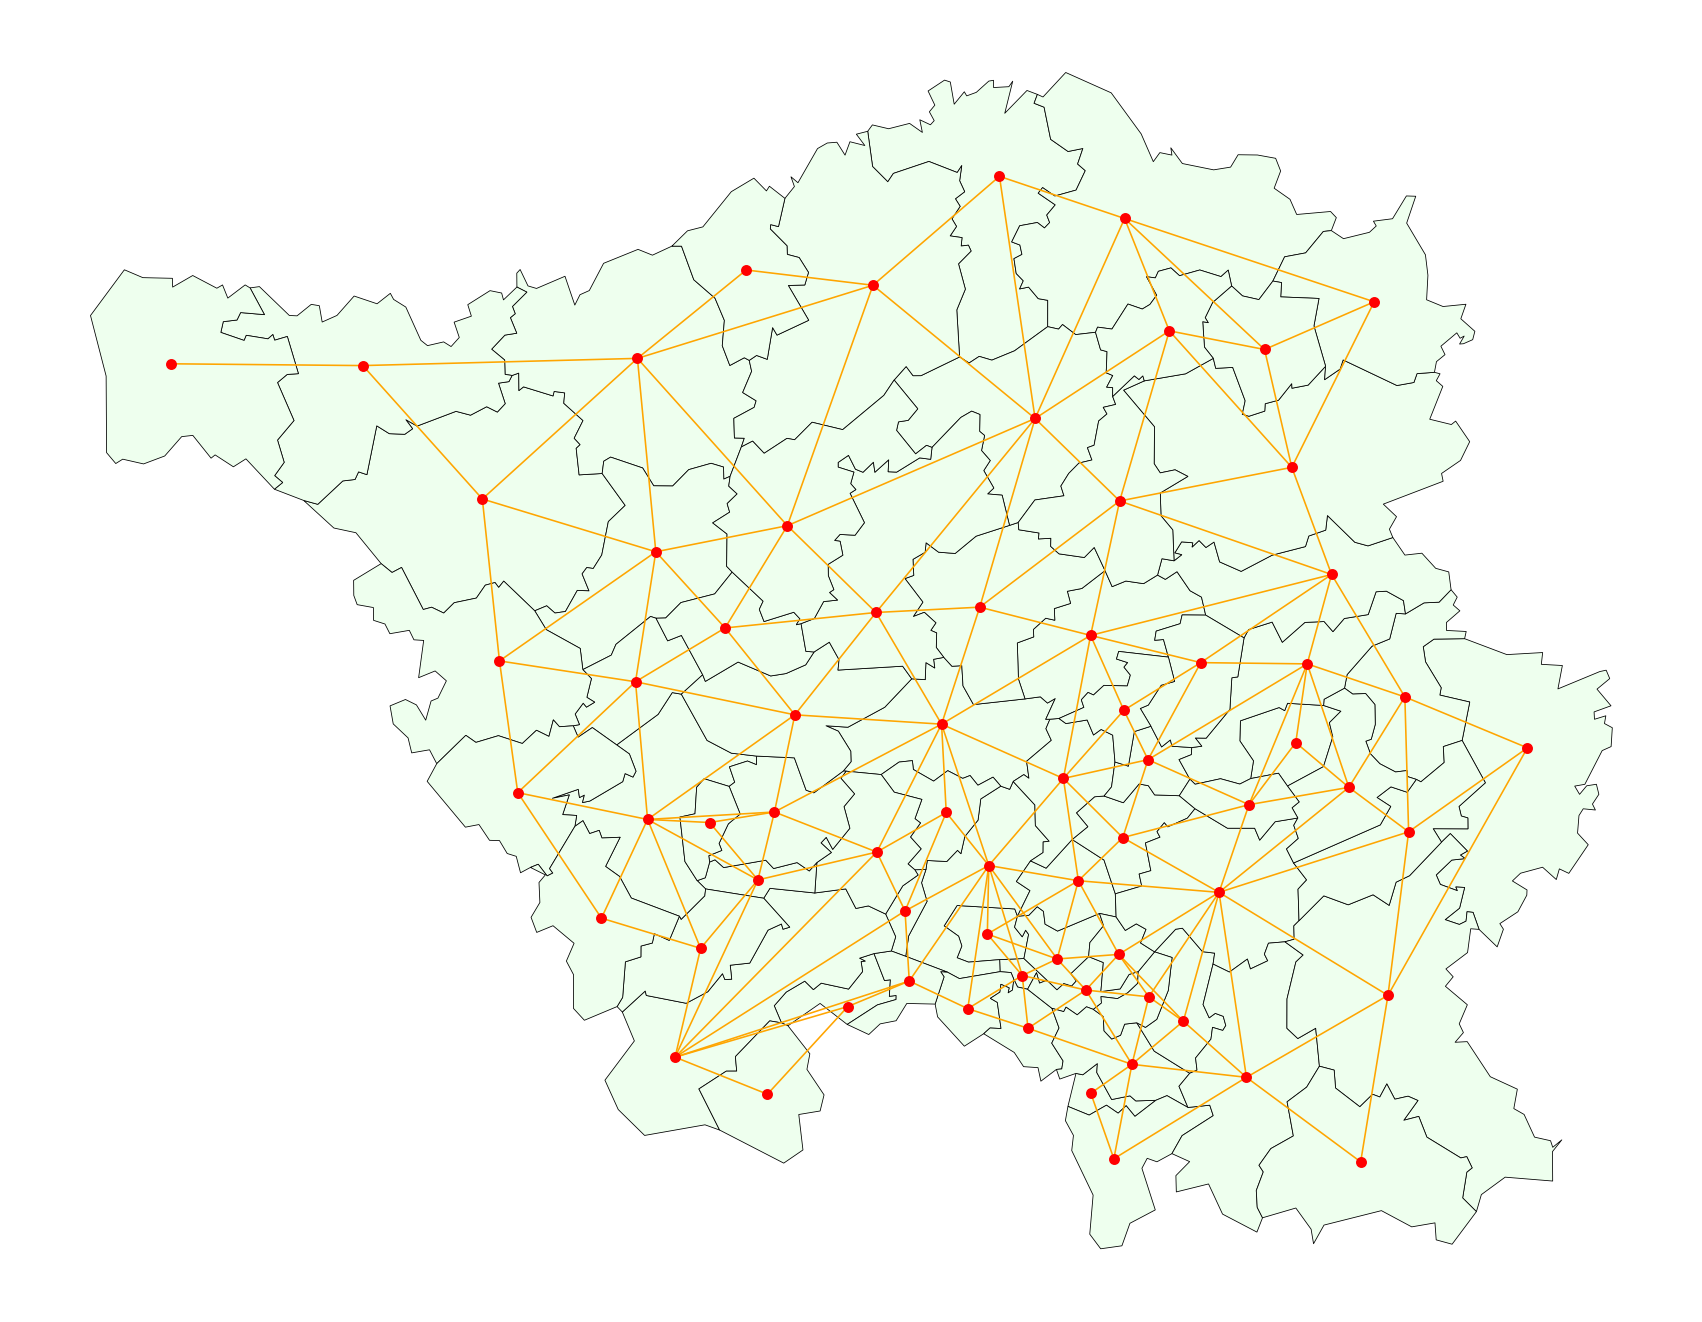

Model the problem.
Upload the model for the pricing problem and the function to create a shortest path tree to tutOR.

Split Saarland into 3 districts with the required district population being equal to 340000.

In [5]:
k = 3
req_p = 340000

Write a function that generates a feasible solution to begin with and return the according patterns. Visualize a feasible solution.

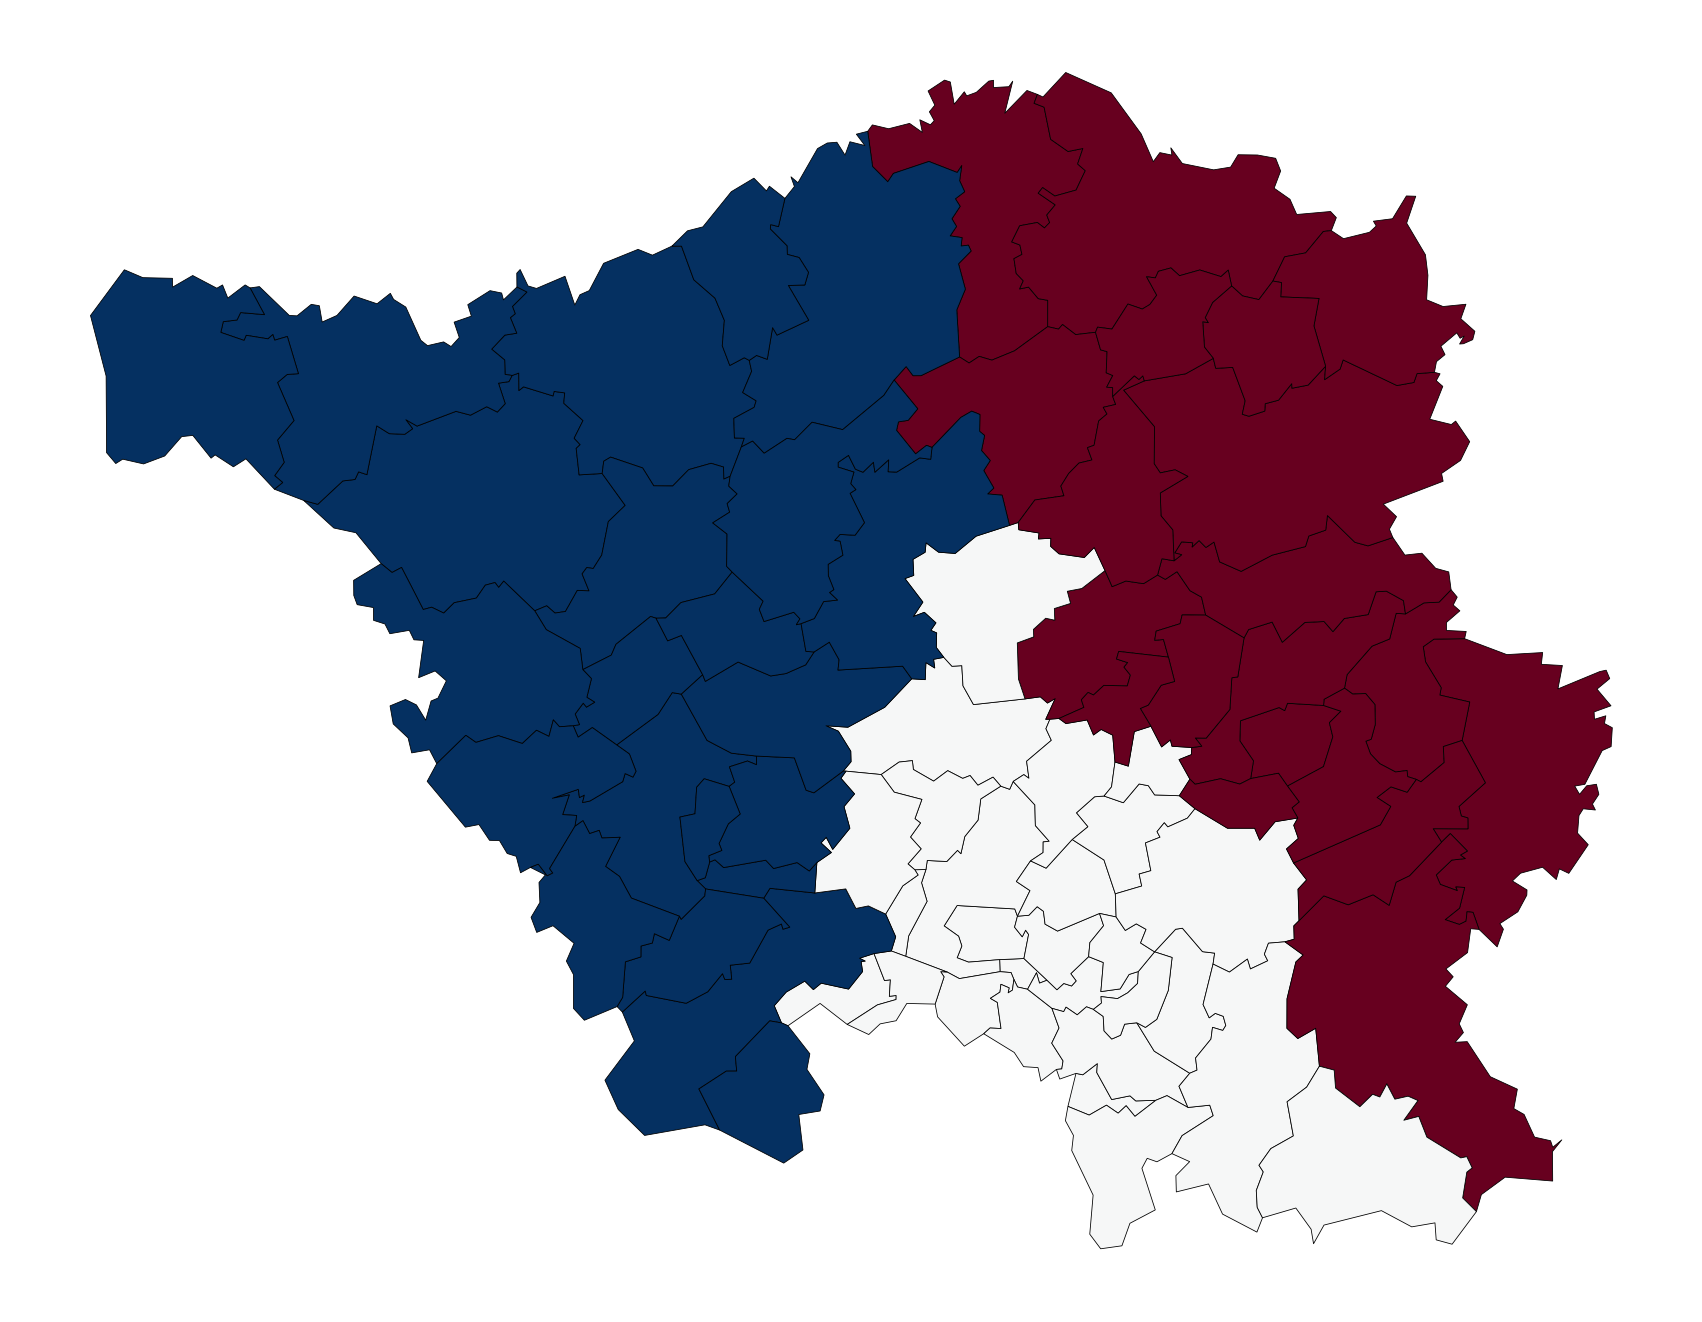

289000.0 < 352165 < 390999.99999999994
289000.0 < 349118 < 390999.99999999994
289000.0 < 299163 < 390999.99999999994


In [6]:
def initialization(TODO):
    return patterns

patterns = initialization(TODO)

Write a function to construct the shortest path tree. Ignore this in the beginning and start implementing the restricted master problem and the pricing problem(s) first. Create the function, when you need it

In [7]:
# takes a graph G and a root node as input and returns a shortest path tree
def construct_spt(G, root):
    return spt

Write a function that contains the pricing problem(s) and that returns the best patterns. Ignore this in the beginning and start implementing the restricted master problem first. Upload the pricing problem and the construct_spt(G, root) function in one file to tutOR

In [8]:
# the pi variables have to be indexed with the municipality ZIP-Codes, this is necessary for tutOR
# pi is a dict containing the dual variable for each constraint. The indices have to be the municipality ZIP-codes. There is one additional dual variable (which one?), it should have index 0
def solve_pricing_problem(G, req_p, pi: dict, u):
    return model

In [9]:
def solve(TODO):
    return model, patterns, first_pattern


In [10]:
model, patterns, first_pattern = solve(TODO)

Visualize the first pattern created. Plot the map of Saarland in the background and a graph which displays the pattern in the foreground

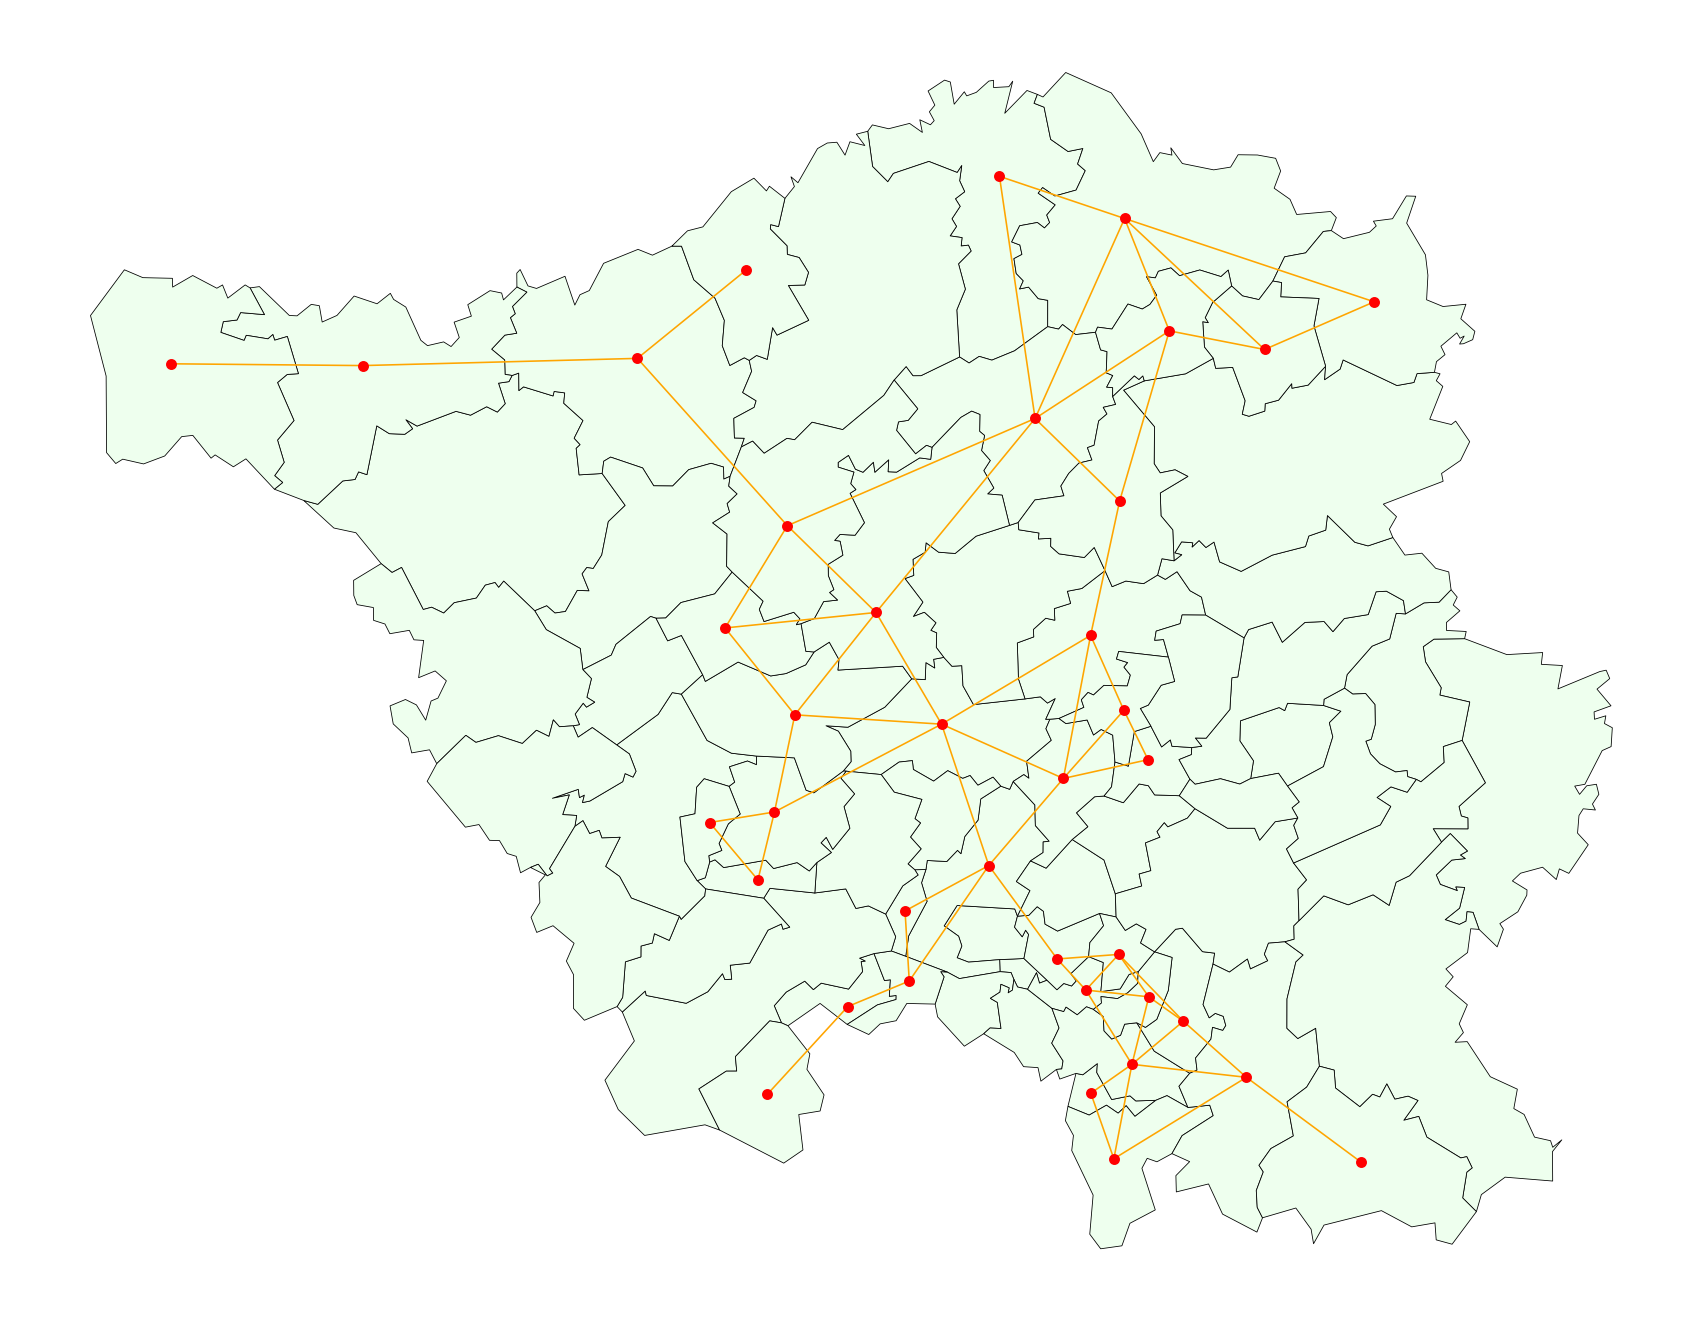

Use the `Gurobi` solution to plot the map of Saarland with each district colored in different color.

For each district:
* check whether the population constraint was satisfied (print the district's population)
* print the names of towns and villages assigned to it

Reference: [sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html)

District 0
Population: 352165 (3.577941176470588 % deviation from 340000)
Towns and villages: 
Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Saarbrücken, Heusweiler, Kleinblittersdorf, Sulzbach/Saar, Quierschied, Riegelsberg, Friedrichsthal, Püttlingen, Sankt Ingbert, Mandelbachtal, Gersheim, Eppelborn, 


District 1
Population: 349118 (2.681764705882353 % deviation from 340000)
Towns and villages: 
Völklingen, Großrosseln, Bous, Merzig, Losheim am See, Wadern, Mettlach, Beckingen, Perl, Weiskirchen, Saarlouis, Dillingen/Saar, Schwalbach, Rehlingen-Siersburg, Wadgassen, Saarwellingen, Wallerfangen, Überherrn, Ensdorf/Saar, Nalbach, Lebach, Schmelz, 


District 2
Population: 299163 (-12.010882352941177 % deviation from 340000)
Towns and villages: 
Homburg, Blieskastel, Bexbach, Kirkel, Neunkirchen, Neunkirchen, Neunkirchen, Illingen, Ottwei